<a href="https://colab.research.google.com/github/FelipeAugus/dio-baires-dev--machine-learning-training-ipynb/blob/main/01-programacao-para-ml/transfer-leanring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

# Preparo das Imagens

In [2]:
!wget --no-check-certificate https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip -O cats-and-dogs.zip
with zipfile.ZipFile('cats-and-dogs.zip', 'r') as zip: zip.extractall('')
!rm -rf cats-and-dogs.zip

--2025-07-17 02:01:44--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.48.252, 2600:1417:3f:580::317f, 2600:1417:3f:5b3::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.48.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘cats-and-dogs.zip’

cats-and-dogs.zip   100%[===================>] 786.67M   121MB/s    in 8.7s    

2025-07-17 02:01:53 (90.1 MB/s) - ‘cats-and-dogs.zip’ saved [824887076/824887076]



In [3]:
try:
    import shutil
    shutil.rmtree('cats-and-dogs')

    os.mkdir('cats-and-dogs')
    os.mkdir('cats-and-dogs/training')
    os.mkdir('cats-and-dogs/testing')
    os.mkdir('cats-and-dogs/training/cats')
    os.mkdir('cats-and-dogs/training/dogs')
    os.mkdir('cats-and-dogs/testing/cats')
    os.mkdir('cats-and-dogs/testing/dogs')
except OSError:
    pass

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE, MAX_SIZE):
    files = []
    current_size = 0
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0 and current_size<=MAX_SIZE:
            files.append(filename)
            current_size+=1
    print(f'Arquivos separados: {len(files)}')

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

CAT_SOURCE_DIR = "PetImages/Cat/"
TRAINING_CATS_DIR = "cats-and-dogs/training/cats/"
TESTING_CATS_DIR = "cats-and-dogs/testing/cats/"
DOG_SOURCE_DIR = "PetImages/Dog/"
TRAINING_DOGS_DIR = "cats-and-dogs/training/dogs/"
TESTING_DOGS_DIR = "cats-and-dogs/testing/dogs/"

split_size = .9
max_size = 120
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size, max_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size, max_size)

print(len(os.listdir('cats-and-dogs/training/cats/')))
print(len(os.listdir('cats-and-dogs/training/dogs/')))
print(len(os.listdir('cats-and-dogs/testing/cats/')))
print(len(os.listdir('cats-and-dogs/testing/dogs/')))

Arquivos separados: 121
Arquivos separados: 121
108
108
13
13


In [4]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.4,
                                   zoom_range = 0.4,
                                   height_shift_range=0.3,
                                   width_shift_range=0.3,
                                   rotation_range=50,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('cats-and-dogs/training',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('cats-and-dogs/testing',
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 216 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


# Instanciando a rede

In [5]:
model=MobileNet(weights='imagenet', include_top=False)
# Criando a saída do modelo MobileNet:
x=model.output
x=GlobalAveragePooling2D()(x)

# Adicionando uma camada intermediária e a camada final:
x=Dense(50,activation='relu')(x)
preds=Dense(1,activation='sigmoid')(x)
model=Model(inputs=model.input, outputs=preds)

# Visualizando as camadas da nova rede criada usando o modelo MobileNetV2:
# for i,layer in enumerate(model.layers): print(i,layer.name)

# Definindo qual camada da rede será treinada. Nesse caso somente as duas últimas camadas adicionadas:
for layer in model.layers[:86]: layer.trainable=False
for layer in model.layers[86:]: layer.trainable=True

/tmp/ipython-input-5-1928709807.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model=MobileNet(weights='imagenet', include_top=False)


# Treinamento

In [6]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(training_set,
                   steps_per_epoch=int(8000/batch_size),
                   epochs=10,
                   validation_data = test_set,
                   validation_steps = int(2000/batch_size))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  7/250 ━━━━━━━━━━━━━━━━━━━━ 3:28 857ms/step - accuracy: 0.5468 - loss: 0.8884

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5643 - loss: 0.8107 - val_accuracy: 0.7308 - val_loss: 0.6216
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6027 - loss: 0.6958 - val_accuracy: 0.7308 - val_loss: 0.5364
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6522 - loss: 0.5965 - val_accuracy: 0.8077 - val_loss: 0.4290
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7623 - loss: 0.5204 - val_accuracy: 0.8462 - val_loss: 0.3609
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7629 - loss: 0.5039 - val_accuracy: 0.9231 - val_loss: 0.3066
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8284 - loss: 0.4381 - val_accuracy: 0.9615 - val_loss: 0.2639
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8421 - loss: 0.3751 - val_accuracy: 0.9615 - val_loss: 0.2285
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8843 - loss: 0.3415 - val_accuracy: 0.9615

# Predição

Loading random image: cats-and-dogs/testing/dogs/11559.jpg


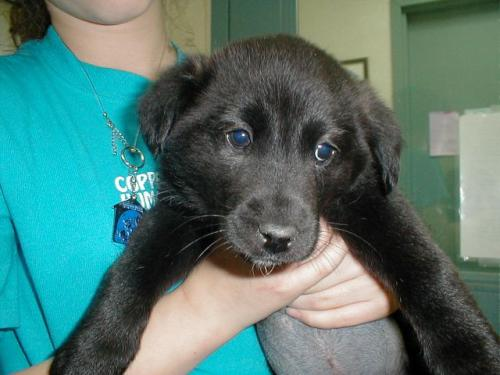

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
dog


In [65]:
# Get list of all test images
cats_test_dir = 'cats-and-dogs/testing/cats/'
dogs_test_dir = 'cats-and-dogs/testing/dogs/'
cats_test_images = [os.path.join(cats_test_dir, f) for f in os.listdir(cats_test_dir) if os.path.isfile(os.path.join(cats_test_dir, f))]
dogs_test_images = [os.path.join(dogs_test_dir, f) for f in os.listdir(dogs_test_dir) if os.path.isfile(os.path.join(dogs_test_dir, f))]

all_test_images = cats_test_images + dogs_test_images

# Select a random image
random_image_path = random.choice(all_test_images)
print(f"Loading random image: {random_image_path}")

test_image = image.load_img(random_image_path, target_size = (224, 224))

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = test_image/255

from IPython import display
display.display(display.Image(random_image_path))

result = model.predict(test_image)

if result[0][0] > 0.5: prediction = 'dog'
else: prediction = 'cat'

print(prediction)